In [18]:
import functions_new as func
import importlib
importlib.reload(func)

###########################################################################################################################################

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from IPython.display import clear_output
import time

In [1]:
import numba
from numba.experimental import jitclass

In [2]:
class System:
    
    
    # creates a system to be simulated. With one reservoir of Agents, and two riot sectors
    def __init__(self, agents, sector0_size, sector1_size):
        self.reservoir = agents
        self.sector0 = np.empty(sector0_size)
        self.sector0_size = sector0_size
        self.sector1 = np.empty(sector1_size)
        self.sector1_size = sector1_size
     
    
    # migrates an Agent "i" from the sector "sector"
    def migrate(self, sector, i):
        if sector == 0:
            agent = self.sector0[i]
            self.sector0 = np.delete(self.sector0, i)
            self.sector1 = np.append(self.sector1, agent)
            
        else:
            agent = self.sector1[i]
            self.sector1 = np.delete(self.sector1, i)
            self.sector0 = np.append(self.sector0, agent)
     
    
    # checks which Agent, in the reservoir, wants to riot according to it's threshold. It can go in sector 0 or 1.         
    def update_wishes_reservoir(self):
        for i in range(len(self.reservoir)):
            num = rd.randint(0,1)
            rnd = rd.random()
            if num == 0:
                if len(self.sector0) < self.sector0_size:
                    percentage = len(self.sector0)/self.sector0_size * 100
                    if rnd <= self.reservoir[i].threshold_model(percentage):
                        self.reservoir[i].wish = 0
                        continue
                
                if len(self.sector1) < self.sector1_size:                    
                    percentage = len(self.sector1)/self.sector1_size * 100
                    if rnd <= self.reservoir[i].threshold_model(percentage):
                        self.reservoir[i].wish = 1
                        continue
                    
            else:
                if len(self.sector1) < self.sector1_size:                    
                    percentage = len(self.sector1)/self.sector1_size * 100
                    if rnd <= self.reservoir[i].threshold_model(percentage):
                        self.reservoir[i].wish = 1
                        continue
                    
                if len(self.sector0) < self.sector0_size:
                    percentage = len(self.sector0)/self.sector0_size * 100
                    if rnd <= self.reservoir[i].threshold_model(percentage):
                        self.reservoir[i].wish = 0
                        continue
    
    
    # checks which Agent, in both sectros, wants to exit the riot.              
    def update_wishes_sectors_exit(self):
        for i in range(len(self.sector0)):
            rnd = rd.random()
            percentage = len(self.sector0)/self.sector0_size * 100
            if rnd > self.sector0[i].threshold_model(percentage):
                self.sector0[i].wish = -1
                
        for i in range(len(self.sector1)):
            rnd = rd.random()
            percentage = len(self.sector1)/self.sector1_size * 100
            if rnd > self.sector1[i].threshold_model(percentage):
                self.sector1[i].wish = -1
     
    
    # checks which Agent, on both sectors, wants to migrate to other sector (random model)
    def update_wishes_sectors_migration_random(self,migration_probability):
        for i in range(len(self.sector0)):
            rnd = rd.random()
            if rnd <= migration_probability:
                self.sector0[i].wish = 1
                
        for i in range(len(self.sector1)):
            rnd = rd.random()
            if rnd <= migration_probability:
                self.sector1[i].wish = 0
                
                
    # checks which Agent, on both sectors, wants to migrate to other sector (gregarious model)             
    def update_wishes_sectors_migration_gregarious(self):
        m = 3*10e-5
        dif = len(system.sector1) - len(system.sector0)
        probability = 1 - np.exp(-m * dif)
        
        for i in range(len(self.sector0)):
            rnd = rd.random()
            if dif > 0 and rnd <= probability:
                self.sector0[i].wish = 1
                
        dif = len(system.sector0) - len(system.sector1)
        probability = 1 - np.exp(-m * dif)
        
        for i in range(len(self.sector1)):
            rnd = rd.random()
            if dif > 0 and rnd <= probability:
                self.sector1[i].wish = 0
    
    
    # moves the Agents from the reservoir to the sectors of their wishes values
    def update_reservoir(self):
        i = 0
        while i < len(self.reservoir):
            if self.reservoir[i].wish == 0 and len(self.sector0) < self.sector0_size:
                agent = self.reservoir[i]
                self.reservoir = np.delete(self.reservoir, i)
                self.sector0 = np.append(self.sector0, agent)
                agent.sector = agent.wish
                i -= 1
            elif self.reservoir[i].wish == 1 and len(self.sector1) < self.sector1_size:
                agent = self.reservoir[i]
                self.reservoir = np.delete(self.reservoir, i)
                self.sector1 = np.append(self.sector1, agent)
                agent.sector = agent.wish
                i -= 1
            else:
                self.reservoir[i].wish = self.reservoir[i].sector
            i += 1
    
    
    # moves the Agents from the sectors to the reservoir or to the other sector
    def update_sectors(self):
        i = 0
        while i < len(self.sector0):
            if self.sector0[i].wish == -1:
                agent = self.sector0[i]
                self.sector0 = np.delete(self.sector0, i)
                self.reservoir = np.append(self.reservoir, agent)
                agent.sector = agent.wish
                i -= 1
            elif self.sector0[i].wish == 1 and len(self.sector1) < self.sector1_size:
                agent = self.sector0[i]
                self.sector0 = np.delete(self.sector0, i)
                self.sector1 = np.append(self.sector1, agent)
                agent.sector = agent.wish
                i -= 1
            else:
                self.reservoir[i].wish = self.reservoir[i].sector
            i += 1
            
        i = 0
        while i < len(self.sector1):
            if self.sector1[i].wish == -1:
                agent = self.sector1[i]
                self.sector1 = np.delete(self.sector1, i)
                self.reservoir = np.append(self.reservoir, agent)
                agent.sector = agent.wish
                i -= 1
            elif self.sector1[i].wish == 0 and len(self.sector0) < self.sector0_size:
                agent = self.sector1[i]
                self.sector0 = np.delete(self.sector1, i)
                self.sector1 = np.append(self.sector0, agent)
                agent.sector = agent.wish
                i -= 1
            else:
                self.reservoir[i].wish = self.reservoir[i].sector
            i += 1

In [3]:
spec = [
    ('threshold', numba.int8),               
    ('wish', numba.int8),
    ('sector', numba.int8),
    ('state', numba.int8),
]

@jitclass(spec)
class Agent:
    
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.wish = -1
        self.sector = -1
        self.state = 0
    
    
    def threshold_model(self, percentage):
        m = 0.2                                                                # if m -> inf, the model approaches the Granovetter's binary model of thresholds.
        probability = 1 / (1 + np.exp( m * (self.threshold - percentage) ) )   # stochastic model of thresholds [0 <= percentage <= 100]
        return probability
    
        
    # updates the state of an agent according with it's threshold, returns 1 if the agent enters the riot, for exemple, and returns 0 if nothing changes.     
    def update_state(self, percentage):              
        rnd = rd.random()
        if self.state == 0:
            if rnd <= self.threshold_model(percentage):
                self.state = 1
                return 1
            else:
                return 0
        else:
            return 0

        
    # updates the state of an agent according with it's threshold, returns 1 if the agent enters the riot, returns 0 if nothing chances and returns -1 if the agent exits the riot.
    def update_state_exit(self, percentage):  
        rnd = rd.random()
        if self.state == 0:
            if rnd <= self.threshold_model(percentage):
                self.state = 1
                return 1
            else:
                return 0
        else:
            if rnd > self.threshold_model(percentage):
                self.state = 0
                return -1
            else:
                return 0

In [5]:
agent = Agent(10)

In [22]:
def create_thresholds(N = 100, a = True, average = 25, deviation = 10):
    """
    Inputs:
        Sample parameters:
          N := total number of agents
          a := if a == True all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100, otherwise nothing happens
        Normal distribution parameters:
          average := average value of the normal distribution
          deviation := standard deviation of the normal distribution
    
    This function creates an array with N threshold values (0 <= x <= 100) according with a normal distribution with the given parameters
          
    Outputs:      
        A np.array with the sorted thresholds values
    
    """
    thresholds = np.empty(N)
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        if a:
            # all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100
            if threshold < 0:
                threshold = 0
            elif threshold > 100:
                threshold = 100

        thresholds[i] = threshold
    print(numba.typeof(thresholds))
    thresholds = sorted(thresholds) #sorts the array
    print(numba.typeof(thresholds))
    return thresholds

In [23]:
%time _ = create_thresholds(100000,10,10)

array(float64, 1d, C)
reflected list(float64)<iv=None>
Wall time: 159 ms


In [92]:
# RUIM #
def create_thresholds(N = 100, a = True, average = 25, deviation = 10):
    """
    Inputs:
        Sample parameters:
          N := total number of agents
          a := if a == True all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100, otherwise nothing happens
        Normal distribution parameters:
          average := average value of the normal distribution
          deviation := standard deviation of the normal distribution
    
    This function creates an array with N threshold values (0 <= x <= 100) according with a normal distribution with the given parameters
          
    Outputs:      
        A np.array with the sorted thresholds values
    
    """
    thresholds = numba.typed.List.empty_list(numba.types.float64)
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        if a:
            # all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100
            if threshold < 0:
                threshold = 0
            elif threshold > 100:
                threshold = 100

        thresholds.append(threshold)
        
    thresholds = sorted(thresholds) #sorts the array
    
    return thresholds

In [24]:
%time _ = create_thresholds(100000,10,10)

array(float64, 1d, C)
reflected list(float64)<iv=None>
Wall time: 162 ms


In [73]:
@numba.njit
def create_thresholds_jit(N = 100, a = True, average = 25, deviation = 10):
    """
    Inputs:
        Sample parameters:
          N := total number of agents
          a := if a == True all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100, otherwise nothing happens
        Normal distribution parameters:
          average := average value of the normal distribution
          deviation := standard deviation of the normal distribution
    
    This function creates an array with N threshold values (0 <= x <= 100) according with a normal distribution with the given parameters
          
    Outputs:      
        A np.array with the sorted thresholds values
    
    """
    thresholds = np.zeros(N, dtype = 'float64')
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        if a:
            # all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100
            if threshold < 0:
                threshold = 0
            elif threshold > 100:
                threshold = 100

        thresholds[i] = threshold
        
    thresholds = sorted(thresholds) #sorts the array
    
    return thresholds

In [27]:
# IGUAL #
@numba.njit
def create_thresholds_jit2(N = 100, a = True, average = 25, deviation = 10):
    """
    Inputs:
        Sample parameters:
          N := total number of agents
          a := if a == True all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100, otherwise nothing happens
        Normal distribution parameters:
          average := average value of the normal distribution
          deviation := standard deviation of the normal distribution
    
    This function creates an array with N threshold values (0 <= x <= 100) according with a normal distribution with the given parameters
          
    Outputs:      
        A np.array with the sorted thresholds values
    
    """
    thresholds = numba.typed.List.empty_list(numba.types.float64)
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        if a:
            # all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100
            if threshold < 0:
                threshold = 0
            elif threshold > 100:
                threshold = 100

        thresholds.append(threshold)
        
    thresholds = sorted(thresholds) #sorts the array
    
    return thresholds

In [75]:
thresholds = create_thresholds_jit(100000,10,10)
numba.typeof(thresholds)

reflected list(float64)<iv=None>

In [30]:
%time _ = create_thresholds_jit2(100000,10,10)

Wall time: 1.19 s


In [116]:
def create_agents(N = 100, average = 25, deviation = 10):
    """
    Inputs:
        N := total number of agents
        average := average value of the normal distribution
        deviation := standard deviation of the normal distribution
        
        The function creates an array of Agents according with the normal distribution of threshold values
        
    Outputs:
        agents := array with all Agents
    
    """
    
    agents = np.empty(N, dtype=Agent)
    
    thresholds = create_thresholds(N, True, average, deviation)
    
    for i in range(N):
        agent = Agent(thresholds[i])
        agents[i] = agent
        
    return agents

In [76]:
@numba.njit
def create_agents_jit(N = 100, average = 25, deviation = 10):
    """
    Inputs:
        N := total number of agents
        average := average value of the normal distribution
        deviation := standard deviation of the normal distribution
        
        The function creates an array of Agents according with the normal distribution of threshold values
        
    Outputs:
        agents := array with all Agents
    
    """
    
    agents = numba.typed.List()
    
    thresholds = create_thresholds_jit(N, True, average, deviation)
    
    for i in range(N):
        agents.append(Agent(thresholds[i]))
        
    return agents

In [11]:
numba.typeof(agent)

instance.jitclass.Agent#21e4cc74048<threshold:int8,wish:int8,sector:int8,state:int8>

In [12]:
agents = numba.typed.List()
agents.append(Agent(thresholds[i]))
print(typeof(agents))

NameError: name 'thresholds' is not defined

In [152]:
%time _ = create_agents(10000,10,10)

Wall time: 171 ms


In [109]:
agents = create_agents_jit(100,0,10)
%time _ = create_agents_jit(100,10,10)

Wall time: 0 ns


In [84]:
@numba.njit
def creat_agent_jit(N):
    agents = numba.typed.List()
    for i in range(N):
        agent = Agent(10)
        agents.append(agent)

    return agent

In [34]:
def creat_agent(N):
    agents = np.empty(N, dtype = Agent)
    for i in range(N):
        agent = Agent(10)
        agents[i]= agent

    return agent

In [40]:
%time _ = creat_agent_jit(100000)

Wall time: 32 ms


In [63]:
%time _ = creat_agent(100000)

Wall time: 1.02 s


In [41]:
def simulate_riot(thresholds):
    
    riot_size = 0
    progression = np.zeros(len(thresholds)+1)    # array that stores the riot's evolution over time
    aux = 0
    
    while True:
        for i in range(1,len(thresholds)):
            if thresholds[i] <= riot_size: # check all Agents and counts which of them enters the riot
                aux += 1
        progression[i] = aux
        if riot_size == aux:   # if the riot size doesn't change in a time step it is stable
            break
        riot_size = aux
        aux = 0
        
    return [progression, riot_size]

In [42]:
@numba.njit(numba.int64[:](numba.float64[:]))
def simulate_riot_jit(thresholds):
    
    riot_size = 0
    progression = np.zeros(len(thresholds)+1, dtype = np.int64)    # array that stores the riot's evolution over time
    aux = 0
    
    while True:
        for i in range(1,len(thresholds)):
            if thresholds[i] <= riot_size: # check all Agents and counts which of them enters the riot
                aux += 1
        progression[i] = aux
        if riot_size == aux:   # if the riot size doesn't change in a time step it is stable
            break
        riot_size = aux
        aux = 0
        
    return progression

In [43]:
@numba.njit(numba.float64[:](numba.int64,numba.int64,numba.int64))
def create_thresholds_jit(N = 100, average = 25, deviation = 10):
    thresholds = np.zeros(N)
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        if threshold < 0:
            threshold = 0
        elif threshold > 100:
            threshold = 100

        thresholds[i] = threshold
        
    #thresholds = sorted(thresholds) #sorts the array
    
    return thresholds

In [44]:
%time _ = simulate_riot(thresholds)

Wall time: 34 ms


In [36]:
from numba import typeof, types

In [45]:
numba.__version__

'0.56.2'

In [46]:
print(numba.typeof(np.empty(10)))
print(numba.typeof(numba.float32[::1]))

array(float64, 1d, C)
typeref[array(float32, 1d, C)]


In [58]:
thresholds = create_thresholds_jit(100000,25,10)

In [89]:
%time _ = simulate_riot_jit(np.array(thresholds))

Wall time: 8.99 ms


In [42]:
a= np.array([10,10,11,12,13,8])
typeof(a)

array(int32, 1d, C)

In [64]:
def simulate_riot_stochastic(agents, steps = 100):
    """
    Inputs:
        agents := Agents array
        steps := number of the simulation's time steps
    
    This function calculates the size of an riot according with the stochastic threshold model: The Agent has a higher probability of entering the riot if its threshold value 
    is less or equal to the number (or percentage) of people rioting, and has a low probability of entering the riot if its threshold value is less than the number (or percentage)
    of people rioting.
    
    Outputs:
        A "answer" np.array with two elements:
            answer[0] := array with the riot's evolution over time
            answer[1] := riot's final size
    
    """
    
    riot_size = 0
    progression = np.zeros(steps+1)              # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        for agent in agents:
            riot_size += agent.update_state(riot_size)
            
        progression[i] = riot_size
        
    return progression

In [68]:
@numba.njit
def simulate_riot_stochastic_jit(agents, steps = 100):
    """
    Inputs:
        agents := Agents array
        steps := number of the simulation's time steps
    
    This function calculates the size of an riot according with the stochastic threshold model: The Agent has a higher probability of entering the riot if its threshold value 
    is less or equal to the number (or percentage) of people rioting, and has a low probability of entering the riot if its threshold value is less than the number (or percentage)
    of people rioting.
    
    Outputs:
        A np.array with the sorted thresholds values
    
    """
    
    riot_size = 0
    progression = np.zeros(steps+1)              # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        for agent in agents:
            riot_size += agent.update_state(riot_size)
            
        progression[i] = riot_size
        
    return progression

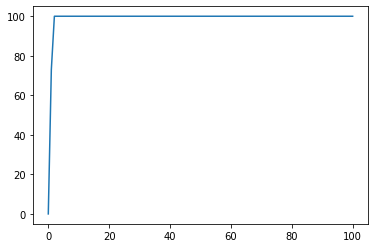

In [118]:
agents = create_agents_jit(100, 25, 10)
pro = simulate_riot_stochastic_jit(agents)
plt.figure()
plt.plot(pro)
#plt.ylim(-5,105)
plt.show()

In [130]:
@numba.njit
def simulate_riot_stochastic_jit2(agents, steps = 100):
    """
    Inputs:
        agents := Agents array
        steps := number of the simulation's time steps
    
    This function calculates the size of an riot according with the stochastic threshold model: The Agent has a higher probability of entering the riot if its threshold value 
    is less or equal to the number (or percentage) of people rioting, and has a low probability of entering the riot if its threshold value is less than the number (or percentage)
    of people rioting.
    
    Outputs:
        A np.array with the sorted thresholds values
    
    """
    
    riot_size = 0
    progression = np.zeros(steps+1)              # array that stores the riot's evolution over time
    aux = 0
    
    for i in range(1,steps+1):
        for agent in agents:
            aux += agent.update_state(riot_size)
        
        
        if aux == 0:
            break
            
        riot_size += aux            
        progression[i] = riot_size
        aux = 0
        
    return progression[:i]

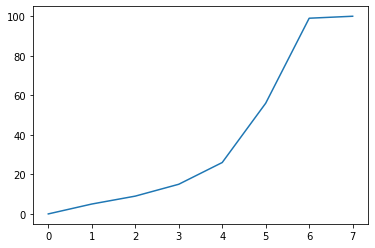

In [131]:
agents = create_agents_jit(100, 25, 10)
pro = simulate_riot_stochastic_jit2(agents)
plt.figure()
plt.plot(pro)
#plt.ylim(-5,105)
plt.show()